# CLASSIFICATION

Tipos de problemas de clasificación

- Binaria
    - Se debe clasificar entre 2 clases (ejemplo: es un perro o un gato)

- Multiclase
    - Se debe clasfificar entre múltiples clases (ejemplo: es un dígito entre el 0 y el 9)

- Multi-output
    - Cada ejemplo puede tener más de 1 etiqueta (ejemplo: en una imagen hay un auto, un árbol y una persona; cualquier combinación de ellos)


## Binary Classification

Recomendaciones en la elección de los hiperparámetros



----> tabla!!!!!




In [4]:
#https://www.kaggle.com/code/ryanholbrook/binary-classification
#https://www.kaggle.com/code/marcosnicolsgarca/exercise-binary-classification/edit

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from tensorflow import keras
from tensorflow.keras import layers

import seaborn as sns

import keras_tuner

2023-11-17 15:20:22.457624: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-17 15:20:22.998416: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-17 15:20:23.000425: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-17 15:20:24.498627: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



### Funciones auxiliares



In [70]:
# graficar la matriz de confusión
def plot_confusion_matrix(y_test,y_pred):
    
    # Create the confusion matrix
    cm = confusion_matrix(y_test,y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize our confusion matrix
    n_classes = cm.shape[0]

    # Let's prettify it
    fig, ax = plt.subplots(figsize=figsize)
    # Create a matrix plot
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    # Create classes
    classes = False

    if classes:
      labels = classes
    else:
      labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
       xlabel="Predicted Label",
       ylabel="True Label",
       xticks=np.arange(n_classes),
       yticks=np.arange(n_classes),
       xticklabels=labels,
       yticklabels=labels)

    # Set x-axis labels to bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Adjust label size
    ax.yaxis.label.set_size(20)
    ax.xaxis.label.set_size(20)
    ax.title.set_size(20)

    # Set threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
           horizontalalignment="center",
           color="white" if cm[i, j] > threshold else "black",
           size=15)
    
    

    
    
# matriz de confusión con TF

def plot_confusion_matrix_tf(y_test,y_pred,labels,figsize=(10,8)):
    plt.figure(figsize=figsize)
    confusion_mtx = tf.math.confusion_matrix(y_test,y_pred)
    sns.heatmap(confusion_mtx,
                xticklabels=labels,
                yticklabels=labels,
                annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()
    
    
# graficar history
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Binary Crossentropy')
    plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
    #plt.ylim([0,5])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Val Accuracy')
    #plt.ylim([0,20])
    plt.legend()
    plt.show()

    
    

In [4]:
# Carga de datos

hotel = pd.read_csv('data/BookingCancellation.csv')

hotel.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,01/07/2015
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,01/07/2015
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,02/07/2015
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,02/07/2015
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,03/07/2015


In [5]:
hotel.shape

(119390, 32)

In [6]:
hotel.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [7]:




"""

# preprocess,

# nulos; var. categóricas.....


#for h in hotel.columns:
#    print(hotel[h].dtype)


#any(palabra in hotel for palabra in palabras_a_verificar)
#hotel[h].dtype=='int64']


palabras_a_verificar = ['int','float']

features_num = [h for h in hotel.columns if any(palabra in str(hotel[h].dtype) for palabra in palabras_a_verificar)]

print(features_num)




['is_canceled', 'lead_time', 
 'arrival_date_year', 
 'arrival_date_week_number', 
 'arrival_date_day_of_month', 
 'stays_in_weekend_nights', 
 'stays_in_week_nights', 
 'adults', 
 'children', 'babies', 'is_repeated_guest', 
 'previous_cancellations', 
 'previous_bookings_not_canceled', 
 'booking_changes', 'agent', 
 'company', 
 'days_in_waiting_list', 'adr', 
 'required_car_parking_spaces', 
 'total_of_special_requests']


features_num2 = [
    "lead_time", 
    "arrival_date_week_number",
    "arrival_date_day_of_month", 
    "stays_in_weekend_nights",
    "stays_in_week_nights", 
    "adults", "children", 
    "babies",
    "is_repeated_guest", 
    "previous_cancellations",
    "previous_bookings_not_canceled", 
    "required_car_parking_spaces",
    "total_of_special_requests", 
    "adr",
]





print(len(features_num ))



print(len(features_num2 ))



columnas_numericas = hotel.select_dtypes(include=['int', 'float'])
list(columnas_numericas.columns)


print(len(columnas_numericas.columns))


"""


'\n\n# preprocess,\n\n# nulos; var. categóricas.....\n\n\n#for h in hotel.columns:\n#    print(hotel[h].dtype)\n\n\n#any(palabra in hotel for palabra in palabras_a_verificar)\n#hotel[h].dtype==\'int64\']\n\n\npalabras_a_verificar = [\'int\',\'float\']\n\nfeatures_num = [h for h in hotel.columns if any(palabra in str(hotel[h].dtype) for palabra in palabras_a_verificar)]\n\nprint(features_num)\n\n\n\n\n[\'is_canceled\', \'lead_time\', \n \'arrival_date_year\', \n \'arrival_date_week_number\', \n \'arrival_date_day_of_month\', \n \'stays_in_weekend_nights\', \n \'stays_in_week_nights\', \n \'adults\', \n \'children\', \'babies\', \'is_repeated_guest\', \n \'previous_cancellations\', \n \'previous_bookings_not_canceled\', \n \'booking_changes\', \'agent\', \n \'company\', \n \'days_in_waiting_list\', \'adr\', \n \'required_car_parking_spaces\', \n \'total_of_special_requests\']\n\n\nfeatures_num2 = [\n    "lead_time", \n    "arrival_date_week_number",\n    "arrival_date_day_of_month", \n  

In [8]:


X = hotel.copy()
y = X.pop('is_canceled')

X['arrival_date_month'] = \
    X['arrival_date_month'].map(
        {'January':1, 'February': 2, 'March':3,
         'April':4, 'May':5, 'June':6, 'July':7,
         'August':8, 'September':9, 'October':10,
         'November':11, 'December':12}
    )


# vars. numéricas
features_num = [
    "lead_time", "arrival_date_week_number",
    "arrival_date_day_of_month", "stays_in_weekend_nights",
    "stays_in_week_nights", "adults", "children", "babies",
    "is_repeated_guest", "previous_cancellations",
    "previous_bookings_not_canceled", "required_car_parking_spaces",
    "total_of_special_requests", "adr",
]

# vars. catg.
features_cat = [
    "hotel", "arrival_date_month", "meal",
    "market_segment", "distribution_channel",
    "reserved_room_type", "deposit_type", "customer_type",
]



# SimpleImputer remplaza los valores faltantes
# StandardScaler -> Standardize features by removing the mean and scaling to unit variance.


# transfomer para las variables numéricas

transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"), # there are a few missing values
    StandardScaler(),
)



# transformer para las categóricas
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore'),
)



# make_column_:transfoerm -> Construct a ColumnTransformer from the given transformers.

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)



# train test split



# stratify - make sure classes are evenlly represented across splits
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, stratify=y, train_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

input_shape = [X_train.shape[1]]


# TIENE MAYOR TAMAÑO POR EL ONE-HOT ENCODING!! (63 en vez de 32)






In [9]:
X_train.shape

(89542, 63)

In [11]:
# primer modelo, bien sencillo

simple_model = keras.Sequential([
    layers.Dense(20,activation='relu',input_shape=input_shape),
    layers.Dense(20,activation='relu'),
    layers.Dense(20,activation='relu'),
    layers.Dense(1,activation='sigmoid'),
])



simple_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


early_stopping = keras.callbacks.EarlyStopping(
        patience=10,
        min_delta=0.001,
        restore_best_weights=True,
    )


history1 = simple_model.fit(
    X_train,y_train,
    #validation_data=(X_test,y_test),
    validation_split=0.2,
    batch_size=512,
    epochs=20,
    callbacks=[early_stopping],
    verbose=0
)





/home/marcos/.local/lib/python3.10/site-packages/keras/engine/data_adapter.py:1700: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]
2023-11-16 16:38:59.925644: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 18051516 exceeds 10% of free system memory.


In [16]:
history_df1 = pd.DataFrame(history1.history)


history_df1.head()



,loss,accuracy,val_loss,val_accuracy
0,0.541124,0.723368,0.449022,0.795466
1,0.423454,0.806723,0.427355,0.803339
2,0.408135,0.811874,0.415705,0.806578
3,0.402876,0.813522,0.412226,0.807192
4,0.398737,0.814499,0.410627,0.810319


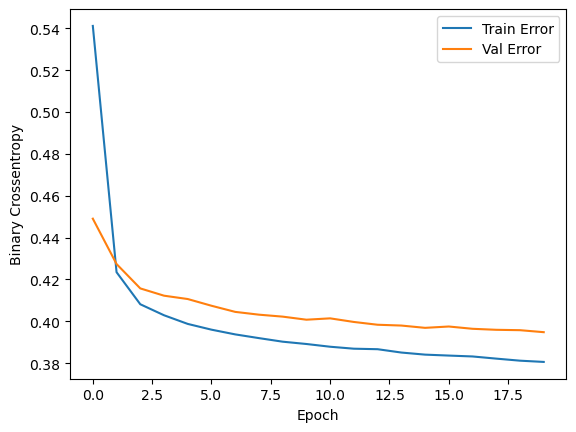

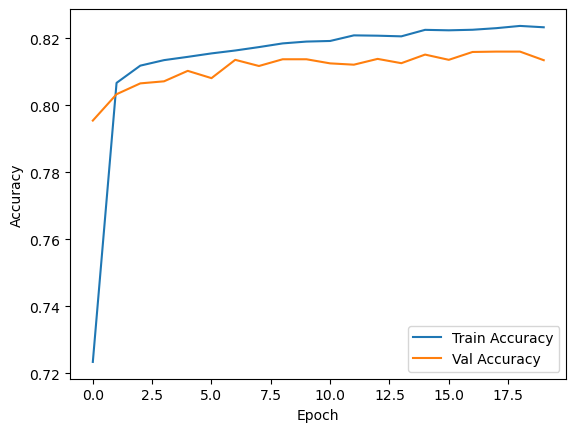

In [21]:
# Start the plot at epoch 5
#history_df1.loc[:5, ['loss', 'val_loss']].plot()

plot_history(history1)


933/933 [==============================] - 1s 677us/step


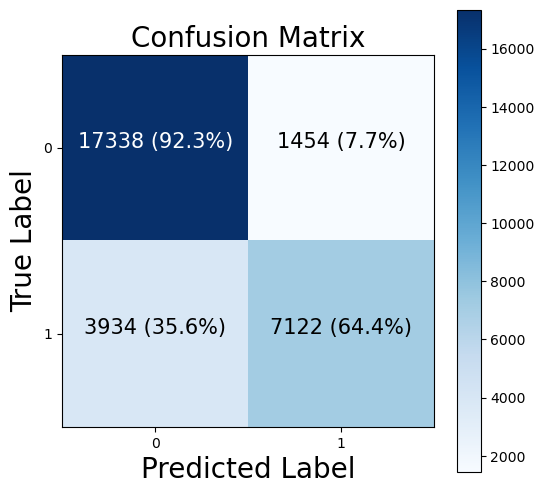

In [22]:
# matriz de confusión

y_preds = simple_model.predict(X_test)

figsize = (6, 6)
  
plot_confusion_matrix(y_test, tf.round(y_preds))

In [29]:
y_test

50988     1
11289     1
20104     0
108150    0
91633     0
         ..
101517    0
89835     0
11179     0
14546     0
96326     0
Name: is_canceled, Length: 29848, dtype: int64

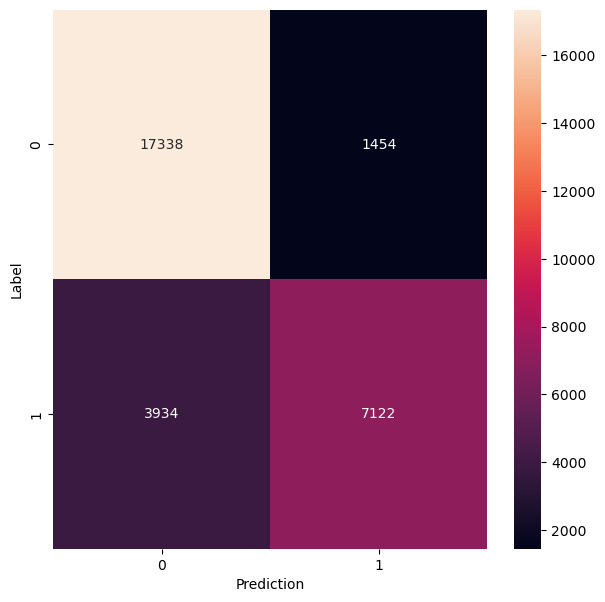

In [58]:
# por practicarme la imprimo usando TF
confusion_mtx = plot_confusion_matrix_tf(y_test, tf.round(y_preds),['0','1'],(7,7))



no anda muy bieN, el mayor problema son los falsos negativos

In [59]:
simple_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                1280      
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,141
Trainable params: 2,141
Non-trainable params: 0
_________________________________________________________________


In [60]:
simple_model.evaluate(X_test,y_test,verbose=2)

933/933 - 1s - loss: 0.3870 - accuracy: 0.8195 - 722ms/epoch - 774us/step


[0.3870476186275482, 0.8194853663444519]

## segundo modelo

In [61]:


model2 = keras.Sequential([
    layers.BatchNormalization(),
    layers.Dense(256,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.3),
    layers.Dense(256,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.3),
    layers.Dense(1,activation='sigmoid')
])


model2.compile(
    optimizer='Adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)



early_stopping = keras.callbacks.EarlyStopping(
        patience=20,
        min_delta=0.001,
        restore_best_weights=True,
    )



history2 = model2.fit(
        X_train,y_train,
        #validation_data=(X_test,y_test),
        validation_split=0.2,
        batch_size=512,
        epochs=40,
        callbacks=[early_stopping],
        verbose=0
)

/home/marcos/.local/lib/python3.10/site-packages/keras/engine/data_adapter.py:1700: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]
2023-11-16 17:06:13.879741: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 18051516 exceeds 10% of free system memory.


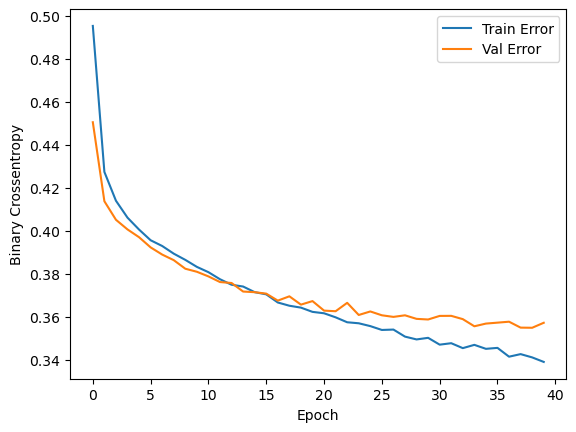

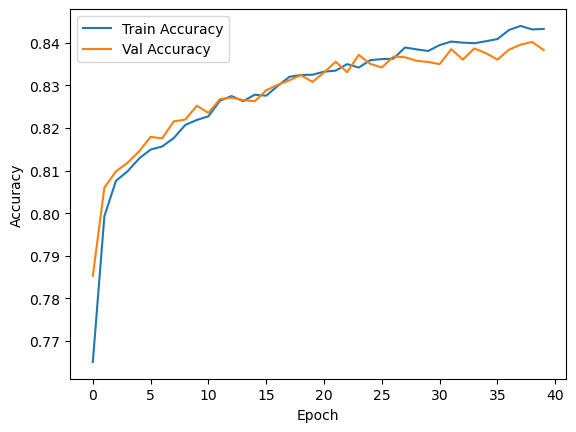

In [62]:
#history_df2 = pd.DataFrame(history2.history)
#history_df2.plot()
#history_df2.loc[:, ['loss', 'val_loss']].plot()

plot_history(history2)



In [63]:
model2.evaluate(X_test,y_test)

933/933 [==============================] - 1s 1ms/step - loss: 0.3593 - accuracy: 0.8366


[0.35933926701545715, 0.8366389870643616]

## ajuste de hiperparámetros para el segundo modelo

In [27]:
# Usaremos Keras Tuner

In [68]:
def build_model(hp):
    model = keras.Sequential([
        layers.BatchNormalization(),
        layers.Dense(hp.Choice('units1', [256, 512]),activation='relu'), #units1
        layers.BatchNormalization(),
        layers.Dropout(hp.Choice('rate1', [0.1, 0.3,0.5])),
        layers.Dense(hp.Choice('units2', [256, 512]),activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(hp.Choice('rate2', [0.1, 0.3,0.5])),
        layers.Dense(1,activation='sigmoid'),
    ])
                     
    lr = hp.Choice("learning_rate",values=[1e-1, 1e-2, 1e-3])
    opt = keras.optimizers.Adam(learning_rate=lr)
    # compile the model
    model.compile(optimizer=opt, loss="binary_crossentropy",
        metrics=["accuracy"])
                     
    return model
    
    

In [69]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5)


In [70]:
tuner.search(X_train, y_train, epochs=5,validation_split=0.2 ) #validation_data=(X_test, y_test)

best_model = tuner.get_best_models()[0]


Trial 5 Complete [00h 00m 34s]
val_loss: 0.9572089910507202

Best val_loss So Far: 0.40387392044067383
Total elapsed time: 00h 04m 36s
INFO:tensorflow:Oracle triggered exit


In [71]:
tuner.results_summary(1)

Results summary
Results in ./untitled_project
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 3 summary
Hyperparameters:
units1: 256
rate1: 0.3
units2: 512
rate2: 0.3
learning_rate: 0.001
Score: 0.40387392044067383


In [72]:
# rentreno con los mejkores hierparams

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
final_model = tuner.hypermodel.build(best_hps)

final_history = final_model.fit(X_train, y_train, epochs=40,validation_split=0.2,verbose=0) 


In [73]:
final_model.evaluate(X_test,y_test)

933/933 [==============================] - 1s 2ms/step - loss: 0.4018 - accuracy: 0.8308


[0.40175187587738037, 0.8307759165763855]

In [74]:
final_history_df = pd.DataFrame(final_history.history) # tiene 40 filas, una por epoch (xq no hubo early stopping)
final_history_df.head()



,loss,accuracy,val_loss,val_accuracy
0,0.460080,0.784080,0.425813,0.802781
1,0.423146,0.802521,0.412397,0.810486
2,0.413477,0.807868,0.407552,0.812385
3,0.407369,0.810827,0.403617,0.812273
4,0.402905,0.813954,0.401837,0.815791


In [3]:
plot_history(final_history)


NameError: name 'final_history' is not defined

## <font color='blue'><b>Clasificación multiclase</b></font>

In [4]:
# MNIST

from tensorflow.keras.datasets import mnist


(train_data, train_labels), (test_data, test_labels) = mnist.load_data()


    If your labels are one-hot encoded, use CategoricalCrossentropy()
    If your labels are integer form use SparseCategoricalCrossentropy()


In [5]:
train_data[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

In [7]:
train_labels[0]

5

In [8]:
train_data[0].shape, train_labels[0].shape

((28, 28), ())

tenemos imágenes 28x28 (en escalas de grises); las etiquetas son un número (x ej. 5 que representa al número 5)

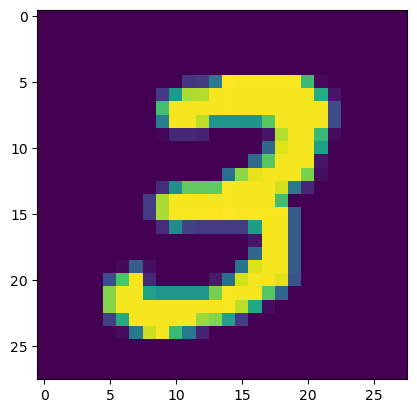

In [9]:
plt.imshow(train_data[7]);

In [10]:
train_labels[7]

3

In [11]:
# aquí es relativamente innecesario poner las clases, pero lo haremos por buena práctica
class_names = [0,1,2,3,4,5,6,7,8,9]

len(class_names)

10

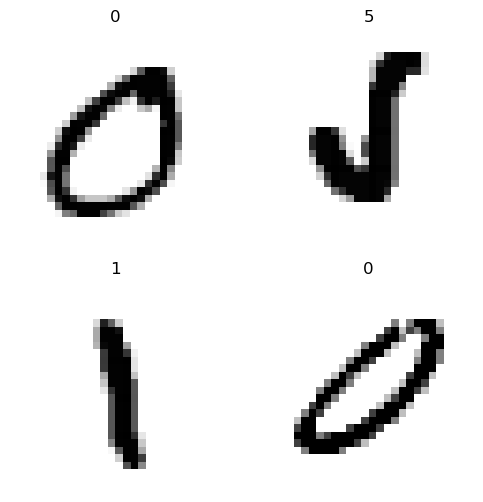

In [14]:
import random 
plt.figure(figsize=(6, 6))
for i in range(4):
  ax = plt.subplot(2, 2, i+1)
  rand_index = random.choice(range(len(train_data)))
  plt.imshow(train_data[rand_index], cmap=plt.cm.binary)
  plt.title(class_names[train_labels[rand_index]])
  plt.axis(False)


CONSTRUCCIÓN DEL MODELO

* Input shape = 28 x 28 (the shape of one image) 
* Output shape = 10 (one per class of clothing)
* Loss function = tf.keras.losses.SparseCategoricalCrosstentropy() (the labels are integers)
* Output layer activation = Softmax

In [21]:
input_shape = (28,28) # tamaño de las imágenes
output_shape = 10 # 10 dígitos


In [17]:
# normalización

print(train_data.min(),train_data.max())



0 255


In [18]:

print('Antes de normalizar: ',train_data.min(),train_data.max())

train_data = train_data/255
test_data = test_data/25

print('Después de normalizar: ',train_data.min(),train_data.max())


Antes de normalizar:  0 255
Después de normalizar:  0.0 1.0


In [42]:
# random seed
tf.random.set_seed(42)



initial_lr = 0.001

# construcción del modelo
def build_model(input_shape,output_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(128,activation='relu'),
        tf.keras.layers.Dense(128,activation='relu'),
        tf.keras.layers.Dense(128,activation='relu'),
        tf.keras.layers.Dense(output_shape,activation='softmax')
    ])
    
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
        metrics=['accuracy']
    )
    
    return model




model1 = build_model(input_shape,output_shape)


# learning rate scheduler como callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch, lr: lr if epoch < 5 else lr * tf.math.exp(-0.1))


# fit
model1_history = model1.fit(
        train_data,
        train_labels,
        validation_split=0.2,
        epochs=8,
        callbacks=[lr_scheduler] 
    )
    
    


Epoch 1/8
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2474 - accuracy: 0.9263 - val_loss: 0.1307 - val_accuracy: 0.9617 - lr: 0.0010
Epoch 2/8
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1058 - accuracy: 0.9668 - val_loss: 0.1253 - val_accuracy: 0.9628 - lr: 0.0010
Epoch 3/8
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0770 - accuracy: 0.9760 - val_loss: 0.1121 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 4/8
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0584 - accuracy: 0.9810 - val_loss: 0.0980 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 5/8
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0469 - accuracy: 0.9847 - val_loss: 0.0968 - val_accuracy: 0.9729 - lr: 0.0010
Epoch 6/8
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0364 - accuracy: 0.9884 - val_loss: 0.1036 - val_accuracy: 0.9729 - lr: 9.0484e-04
Epoch 7/8
1500/1500 [==============================] - 4s 3m

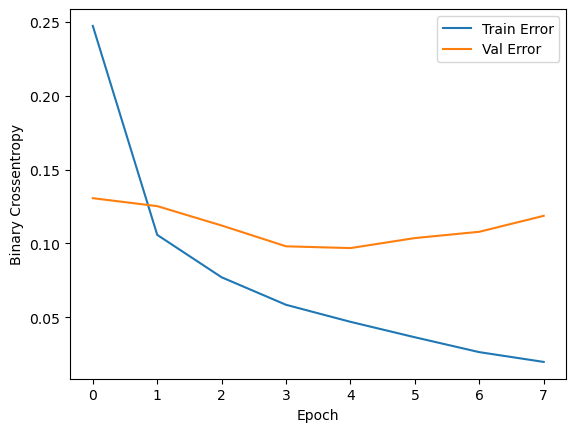

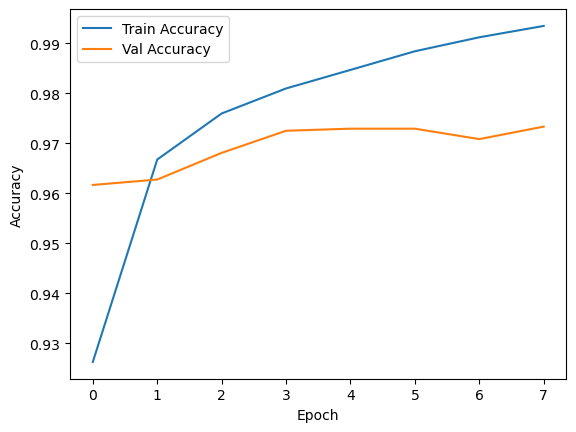

In [44]:
plot_history(model1_history)

estas gráficas nos hacen pensar que el modelo tiene overfitting (hay una brecha significativa entre ambas curvas)

In [45]:
model1.evaluate(test_data,test_labels)

313/313 [==============================] - 0s 1ms/step - loss: 0.8039 - accuracy: 0.9782


[0.8038875460624695, 0.9782000184059143]

In [48]:

# Mismo modelo pero agregando dropout por el overfitting


# random seed
tf.random.set_seed(42)



initial_lr = 0.001

# construcción del modelo
def build_model2(input_shape,output_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(128,activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128,activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128,activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(output_shape,activation='softmax')
    ])
    
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
        metrics=['accuracy']
    )
    
    return model




model2 = build_model2(input_shape,output_shape)


# learning rate scheduler como callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch, lr: lr if epoch < 5 else lr * tf.math.exp(-0.1))


# fit
model2_history = model2.fit(
        train_data,
        train_labels,
        validation_split=0.2,
        epochs=8,
        callbacks=[lr_scheduler] 
    )
    


Epoch 1/8
1500/1500 [==============================] - 6s 3ms/step - loss: 0.4384 - accuracy: 0.8651 - val_loss: 0.1565 - val_accuracy: 0.9532 - lr: 0.0010
Epoch 2/8
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2209 - accuracy: 0.9357 - val_loss: 0.1257 - val_accuracy: 0.9624 - lr: 0.0010
Epoch 3/8
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1717 - accuracy: 0.9494 - val_loss: 0.1270 - val_accuracy: 0.9634 - lr: 0.0010
Epoch 4/8
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1534 - accuracy: 0.9553 - val_loss: 0.1042 - val_accuracy: 0.9685 - lr: 0.0010
Epoch 5/8
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1343 - accuracy: 0.9603 - val_loss: 0.1052 - val_accuracy: 0.9693 - lr: 0.0010
Epoch 6/8
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1194 - accuracy: 0.9654 - val_loss: 0.0935 - val_accuracy: 0.9740 - lr: 9.0484e-04
Epoch 7/8
1500/1500 [==============================] - 4s 3m

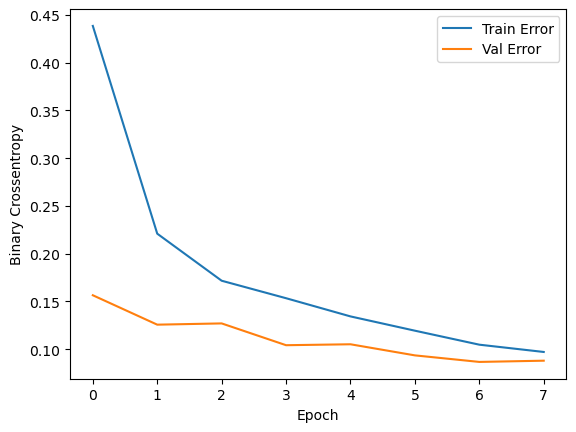

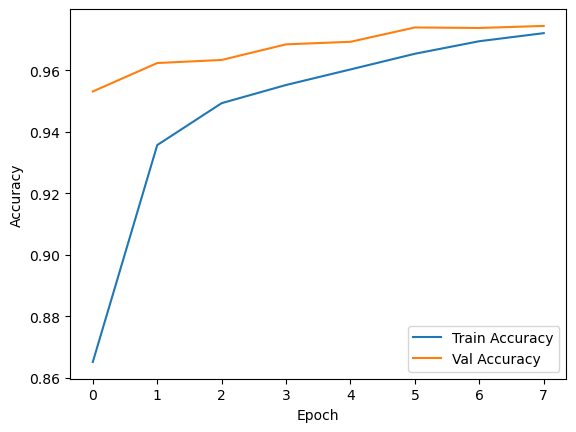

In [49]:
plot_history(model2_history)

In [50]:
model2.evaluate(test_data,test_labels)

313/313 [==============================] - 0s 1ms/step - loss: 0.5989 - accuracy: 0.9728


[0.5989049077033997, 0.9728000164031982]

### Ajuste de hiperparámetros

In [58]:

# construcción del modelo
def build_model3(hp,input_shape,output_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(hp.Choice('units1', [128,256, 512]),activation='relu'),
        layers.Dropout(hp.Choice('rate1', [0.1, 0.3,0.5])),
        tf.keras.layers.Dense(hp.Choice('units2', [128,256, 512]),activation='relu'),
        layers.Dropout(hp.Choice('rate2', [0.1, 0.3,0.5])),
        tf.keras.layers.Dense(hp.Choice('units3', [128,256, 512]),activation='relu'),
        layers.Dropout(hp.Choice('rate3', [0.1, 0.3,0.5])),
        tf.keras.layers.Dense(output_shape,activation='softmax')
    ])
    
    initial_lr = hp.Choice("learning_rate",values=[1e-1, 1e-2, 1e-3])
    opt = keras.optimizers.Adam(learning_rate=initial_lr)
    
    
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=opt,
        metrics=['accuracy']
    )
    
    return model





In [61]:
tuner = keras_tuner.BayesianOptimization(
        lambda hp:build_model3(hp,input_shape,output_shape),
        objective='val_loss',
        max_trials=5,
        directory='my_tuning_directory',
        project_name='digit_classification'
)



In [62]:
tuner.search(test_data, test_labels, epochs=5,validation_split=0.2 ) 

Trial 5 Complete [00h 00m 11s]
val_loss: 1.6377360820770264

Best val_loss So Far: 0.1706949770450592
Total elapsed time: 00h 01m 15s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [63]:
best_model = tuner.get_best_models()[0]

In [64]:
tuner.results_summary(1)

Results summary
Results in my_tuning_directory/digit_classification
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 1 summary
Hyperparameters:
units1: 512
rate1: 0.5
units2: 128
rate2: 0.3
units3: 512
rate3: 0.1
learning_rate: 0.001
Score: 0.1706949770450592


In [66]:
# re-entreno con los mejores params
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
final_model = tuner.hypermodel.build(best_hps)

final_history = final_model.fit(train_data, train_labels, epochs=20,validation_split=0.2,verbose=0)

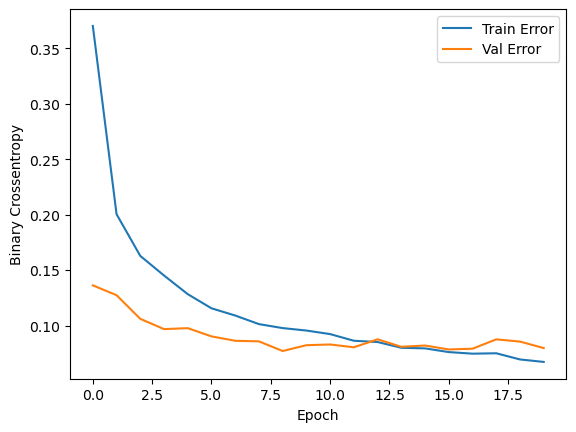

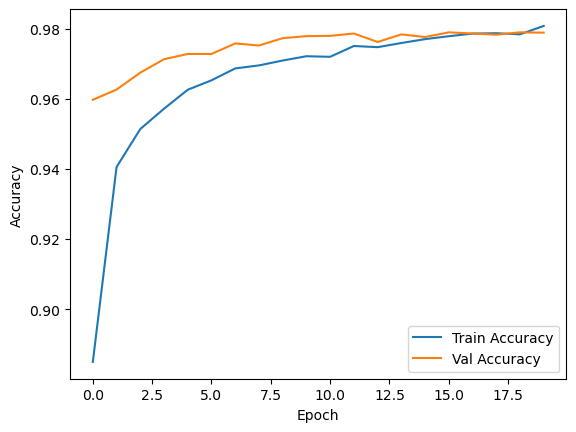

In [67]:
plot_history(final_history)

In [68]:
final_model.evaluate(test_data,test_labels)

313/313 [==============================] - 1s 2ms/step - loss: 0.5477 - accuracy: 0.9796


[0.5477474331855774, 0.9796000123023987]

### matriz de confusión

313/313 [==============================] - 1s 2ms/step


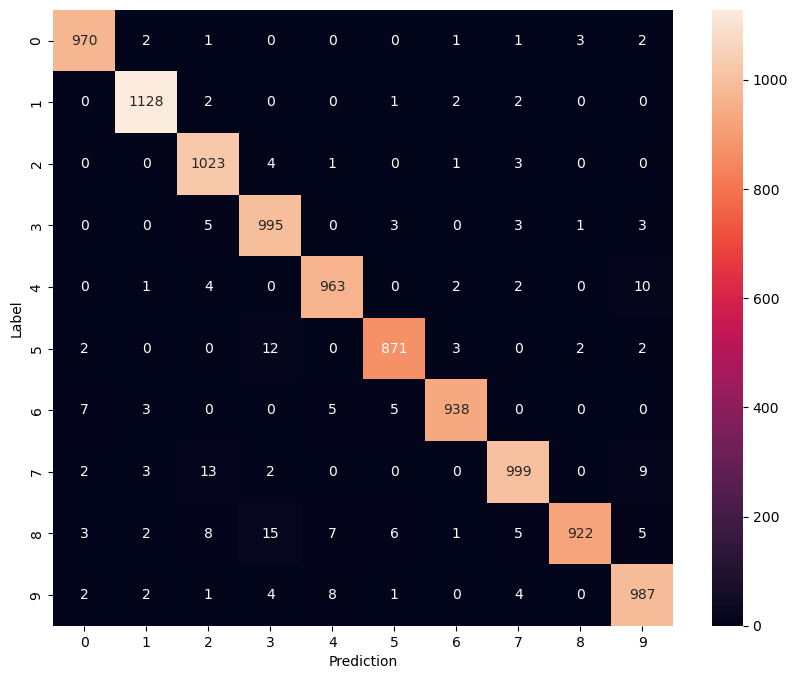

In [98]:

y_probs = final_model.predict(test_data) # esto da probabilidades de salida!
y_preds = y_probs.argmax(axis=1)


plot_confusion_matrix_tf(test_labels,y_preds,class_names)



Instancia 234: Clase Verdadera: 8, Clase Predicha: 3
Instancia 248: Clase Verdadera: 4, Clase Predicha: 2
Instancia 260: Clase Verdadera: 6, Clase Predicha: 0
Instancia 322: Clase Verdadera: 2, Clase Predicha: 7
Instancia 341: Clase Verdadera: 5, Clase Predicha: 3


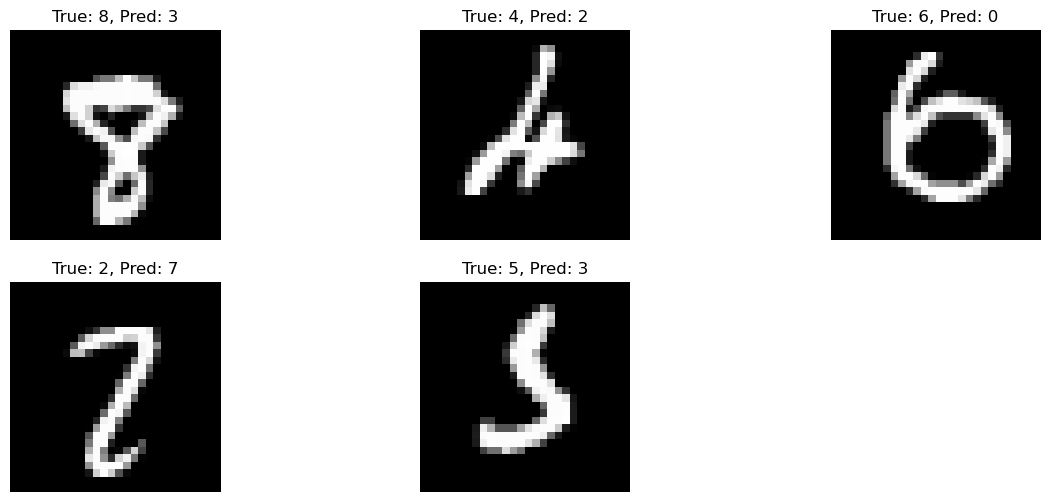

In [103]:

# Encuentra índices de malas predicciones
incorrect_indices = np.where(test_labels != y_preds)[0]

# Visualiza algunas de las malas predicciones en dos columnas
num_samples_to_visualize = min(5, len(incorrect_indices))
num_columns = 3
num_rows = (num_samples_to_visualize + 1) // num_columns
plt.figure(figsize=(15, 3 * num_rows))

for i in range(num_samples_to_visualize):
    index = incorrect_indices[i]
    
    # Imprime la clase verdadera y la clase predicha
    true_class = test_labels[index]
    predicted_class = y_preds[index]
    print(f'Instancia {index + 1}: Clase Verdadera: {true_class}, Clase Predicha: {predicted_class}')

    # Visualiza la instancia (cambia según tus datos y formato)
    plt.subplot(num_rows, num_columns, i + 1)
    plt.imshow(test_data[index], cmap='gray')  # Ajusta según el formato de tus datos
    plt.title(f'True: {true_class}, Pred: {predicted_class}')
    plt.axis('off')

plt.show()
